# 0.Libraries

In [3]:
import os
import cv2
import tkinter as tk
from tkinter import simpledialog
import mediapipe as mp
import matplotlib.pyplot as plt

# blank comment and added on more comment



import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import save_model



from tensorflow.keras.models import load_model


# 1.DATA COLLECTION UTPTO 1000 images per label
- here we detct the input from users camera and save the images in the respective folder
- also the part of image containing hand is saved by cropping it 
- the only problem in this is with gestures requiring two hands
- to solve this issue a diffrent approach need to be seen.

In [4]:
def cptr_crop(nm_img):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
    mp_drawing = mp.solutions.drawing_utils
    
    
    fldName = "CollectedData"
    if not os.path.exists(fldName):
        os.makedirs(fldName)
    
    cap = cv2.VideoCapture(0)
    print("Press 's' to save the cropped hand image with label, or 'q' to quit.")
    
    img_cnt = 0
    
    while img_cnt < nm_img:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture image")
            break
        
    
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rslt = hands.process(img_rgb)
        
    
        if rslt.multi_hand_landmarks:
            for hand_landmarks in rslt.multi_hand_landmarks:
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        
        
        cv2.imshow("Capture Image with Landmarks", frame)
        #caputerr the imae with label and landmarkkk
        
        
        
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord('s') and img_cnt < nm_img:  
        
            root = tk.Tk()
            root.withdraw()
            label = simpledialog.askstring("Input", "Enter the label for this image:")
            root.destroy()
            
            
            # Take lanbel inpute from the user ....
            #The only problem is that for a single label user had to enter same text multiple time 
            # problem need to be considered i think it can be resolved using the previously used GUI interface ... handeled later
            
            
            if label and rslt.multi_hand_landmarks:
                
                label_dir = os.path.join(fldName, label)
                
                if not os.path.exists(label_dir):
                    os.makedirs(label_dir)
                
                for idx, hand_landmarks in enumerate(rslt.multi_hand_landmarks):
                    
                    img_h, img_w, _ = frame.shape
                    x_min, y_min = img_w, img_h
                    x_max, y_max = 0, 0
                    
                    for landmark in hand_landmarks.landmark:
                        x, y = int(landmark.x * img_w), int(landmark.y * img_h)
                        x_min, y_min = min(x, x_min), min(y, y_min)
                        x_max, y_max = max(x, x_max), max(y, y_max)
                    
                    
                    padding = 20
                    x_min = max(0, x_min - padding)
                    y_min = max(0, y_min - padding)
                    x_max = min(img_w, x_max + padding)
                    y_max = min(img_h, y_max + padding)
                    
                    
                    cropped_hand = frame[y_min:y_max, x_min:x_max]
                    
                    
                    file_count = len(os.listdir(label_dir)) + 1 
                    file_name = os.path.join(label_dir, f"{file_count}.jpg")
                    cv2.imwrite(file_name, cropped_hand)
                    print(f"Cropped hand image saved as {file_name}")
                    img_cnt += 1
                    
                    
                    if img_cnt >= nm_img:
                        break
            else:
                print("No hand detected or label not provided.")
        
        elif key == ord('q'):  
            break

    cap.release()
    cv2.destroyAllWindows()


cptr_crop(nm_img=100) 
# The only isssue with this part was saving multiple images with same label was not possible 
# so the thought was to make separate folder for each label and insert a multiple images in that folder 
# the labels will be later handeled using label encoder or any other technique 

# Code running fine with no errors debugging not done

Press 's' to save the cropped hand image with label, or 'q' to quit.
Failed to capture image


# 2. Loading the data and using label encoder

In [5]:
def load_data(fldName):
    images = []
    labels = []
    
    for label in os.listdir(fldName):
        label_dir = os.path.join(fldName, label)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Image at {img_path} is not valid and will be skipped.")
                continue
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
            img = cv2.resize(img, (128, 128)) 
            images.append(img)
            labels.append(label)
    
    images = np.array(images) / 255.0 
    labels = np.array(labels)
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    np.save('label_class.npy', label_encoder.classes_)
    
    
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
    
    return x_train, x_test, y_train, y_test

# LAbel encoder seems fine for now no error saved label of encoder so that we can revert back them to respective labels 

# 3. Building a MODEL

In [6]:
fldName = "CollectedData"
x_train, x_test, y_train, y_test = load_data(fldName)

#### 3.1. CNN model (model1)

In [ ]:
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(len(np.unique(y_train)), activation='softmax')  # Number of output classes
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model





model = build_model()


history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)
model_save_path = 'models/model1.h5'


model.save(model_save_path)

print(f"Model saved to {model_save_path}")

c:\Users\KIIT\Desktop\Sign_language\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 22s 203ms/step - accuracy: 0.5865 - loss: 1.5378 - val_accuracy: 0.9694 - val_loss: 0.1111
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 238ms/step - accuracy: 0.9852 - loss: 0.0668 - val_accuracy: 0.9809 - val_loss: 0.0532
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - accuracy: 0.9944 - loss: 0.0180 - val_accuracy: 0.9822 - val_loss: 0.0643
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 26s 258ms/step - accuracy: 0.9951 - loss: 0.0123 - val_accuracy: 0.9936 - val_loss: 0.0240
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - accuracy: 0.9968 - loss: 0.0070 - val_accuracy: 0.9924 - val_loss: 0.0214
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 242ms/step - accuracy: 0.9991 - loss: 0.0014 - val_accuracy: 0.9911 - val_loss: 0.0280
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 246ms/step - accuracy: 1.0000 - loss: 4.1528e-04 - val_accuracy: 0.9911 - val_loss: 0.0267
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - accuracy: 1.0000 - loss: 3.7618e-05 - 

Model saved to models/model1.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      0.96      0.98        49
           2       1.00      1.00      1.00        46
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        43
           5       1.00      1.00      1.00       100
           6       1.00      1.00      1.00        46
           7       1.00      1.00      1.00        45
           8       0.90      1.00      0.95        28
           9       0.96      0.88      0.92        26
          10       1.00      1.00      1.00        10
          11       0.92      1.00      0.96        22
          12       1.00      0.94      0.97        18
          13       1.00      1.00      1.00        19
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00        17
          16       1.00      1.00      1.

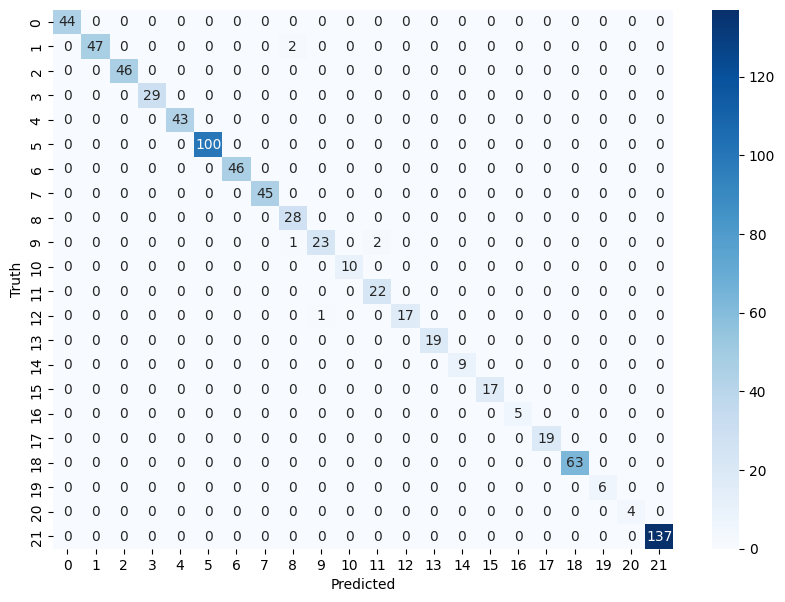

In [ ]:
# model accuracy ,precision, recall, F1-score values, confusion matrix.
model = load_model('./models/model1.h5')
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()



#### 3.2 CNN 2 model(model 2)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

fldName = "CollectedData"
x_train, x_test, y_train, y_test = load_data(fldName)


model = build_model()


history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=6, batch_size=32)
model_save_path = 'models/model2.h5'


model.save(model_save_path)

print(f"Model saved to {model_save_path}")

c:\Users\KIIT\Desktop\Sign_language\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\KIIT\Desktop\Sign_language\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
99/99 ━━━━━━━━━━━━━━━━━━━━ 32s 291ms/step - accuracy: 0.6363 - loss: 1.3769 - val_accuracy: 0.9669 - val_loss: 0.1321
Epoch 2/6
99/99 ━━━━━━━━━━━━━━━━━━━━ 25s 251ms/step - accuracy: 0.9829 - loss: 0.0715 - val_accuracy: 0.9822 - val_loss: 0.1031
Epoch 3/6
99/99 ━━━━━━━━━━━━━━━━━━━━ 24s 241ms/step - accuracy: 0.9928 - loss: 0.0353 - val_accuracy: 0.9924 - val_loss: 0.0350
Epoch 4/6
99/99 ━━━━━━━━━━━━━━━━━━━━ 25s 254ms/step - accuracy: 0.9963 - loss: 0.0137 - val_accuracy: 0.9911 - val_loss: 0.0333
Epoch 5/6
99/99 ━━━━━━━━━━━━━━━━━━━━ 25s 255ms/step - accuracy: 0.9982 - loss: 0.0075 - val_accuracy: 0.9962 - val_loss: 0.0133
Epoch 6/6
99/99 ━━━━━━━━━━━━━━━━━━━━ 26s 260ms/step - accuracy: 0.9994 - loss: 0.0017 - val_accuracy: 0.9949 - val_loss: 0.0140


Model saved to models/model2.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 315ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       1.00      0.96      0.98        49
           2       1.00      1.00      1.00        46
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        43
           5       1.00      1.00      1.00       100
           6       1.00      1.00      1.00        46
           7       1.00      1.00      1.00        45
           8       1.00      1.00      1.00        28
           9       0.89      0.96      0.93        26
          10       1.00      1.00      1.00        10
          11       0.95      0.95      0.95        22
          12       1.00      1.00      1.00        18
          13       1.00      1.00      1.00        19
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00        17
          16       1.00      1.00      1

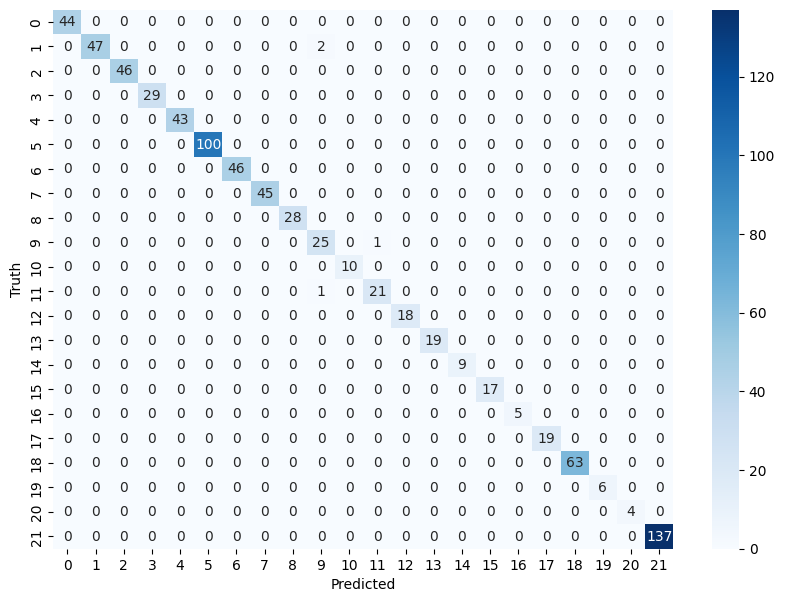

In [ ]:
model = load_model('./models/model2.h5')
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

#### 3.3 MobileNetV2(model 3)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(len(np.unique(y_train)), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False  # Freeze base layers
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

fldName = "CollectedData"
x_train, x_test, y_train, y_test = load_data(fldName)

models_folder = "models"
if not os.path.exists(models_folder):
    os.makedirs(models_folder)

# Save the model
model_path = os.path.join(models_folder, "model3.h5")
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to models\model3.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step
              precision    recall  f1-score   support

           0       0.02      0.09      0.03        44
           1       0.00      0.00      0.00        49
           2       0.12      0.09      0.10        46
           3       0.00      0.00      0.00        29
           4       0.00      0.00      0.00        43
           5       0.00      0.00      0.00       100
           6       0.07      0.52      0.12        46
           7       0.00      0.00      0.00        45
           8       0.00      0.00      0.00        28
           9       0.00      0.00      0.00        26
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00        22
          12       0.00      0.00      0.00        18
          13       0.00      0.00      0.00        19
          14       0.00      0.00      0.00         9
          15       0.00      0.00      0.00        17
          16       0.00      0.00      0

c:\Users\KIIT\Desktop\Sign_language\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\KIIT\Desktop\Sign_language\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\KIIT\Desktop\Sign_language\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

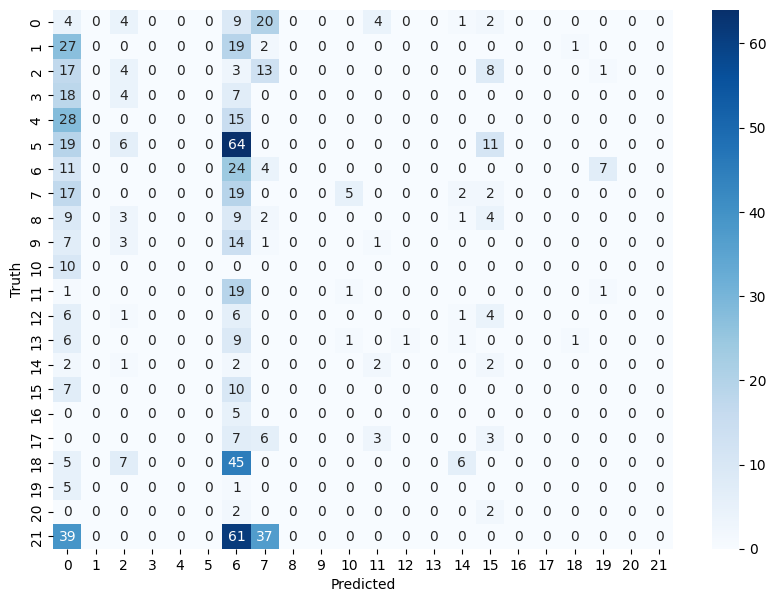

In [ ]:
model = load_model('./models/model3.h5')
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [7]:
#peek into label_class.npy file
import numpy as np
label_class = np.load('label_class.npy')
print(label_class)

['Again' 'Agree' 'Answer' 'Hello' 'SICK' 'SUN' 'THIS' 'VICTORY'
 'attendance' 'book' 'break' 'careful' 'chat' 'congratulation' 'email'
 'good morning' 'keep smiling' 'meet' 'mistake' 'ok' 'opinion'
 'understand']


**Note: STILL WORKING ON THIS PART .**


# <span style="color:red;"> DO NOT TOUCH THIS CELL </span>

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define an Inception module
def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj):
    # 1x1 convolution branch
    branch1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    # 3x3 convolution branch
    branch3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    branch3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(branch3x3)

    # 5x5 convolution branch
    branch5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    branch5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(branch5x5)

    # Max pooling branch
    branch_pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(branch_pool)

    # Concatenate all branches
    output = concatenate([branch1x1, branch3x3, branch5x5, branch_pool], axis=-1)
    return output

# Define the input shape
input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)

# Initial convolutional layer
x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Inception modules
x = inception_module(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool_proj=32)
x = inception_module(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool_proj=64)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = inception_module(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool_proj=64)

# Global Average Pooling
x = AveragePooling2D((7, 7))(x)
x = Flatten()(x)

# Fully connected layers
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)

# Output layer
outputs = Dense(len(np.unique(y_train)), activation='softmax')(x)

# Create the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Ensure x_train and y_train have the same number of samples
if len(x_train) != len(y_train):
    min_samples = min(len(x_train), len(y_train))
    x_train = x_train[:min_samples]
    y_train = y_train[:min_samples]

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001),
               EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)
model_save_path = 'models/model3_1.h5'


model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model: "functional_72"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 64, 64,    │      9,472 │ input_layer_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 32, 32,    │          0 │ conv2d_67[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 32, 32,    │      6,240 │ max_pooling2d_25… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 32, 32,    │      1,040 │ max_pooling2d_25… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_26    │ (None, 32, 32,    │          0 │ max_pooling2d_25… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 32, 32,    │      4,160 │ max_pooling2d_25… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 32, 32,    │    110,720 │ conv2d_69[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 32, 32,    │     12,832 │ conv2d_71[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 32, 32,    │      2,080 │ max_pooling2d_26… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 32, 32,    │          0 │ conv2d_68[0][0],  │
│ (Concatenate)       │ 256)              │            │ conv2d_70[0][0],  │
│                     │                   │            │ conv2d_72[0][0],  │
│                     │                   │            │ conv2d_73[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 32, 32,    │     32,896 │ concatenate_9[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 32, 32,    │      8,224 │ concatenate_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_27    │ (None, 32, 32,    │          0 │ concatenate_9[0]… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 32, 32,    │     32,896 │ concatenate_9[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 32, 32,    │    221,376 │ conv2d_75[0][0]   │
│                     │ 192)              │            │                 

 Total params: 3,545,718 (13.53 MB)

 Trainable params: 3,545,718 (13.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 861ms/step - accuracy: 0.1183 - loss: 2.9526 - val_accuracy: 0.1571 - val_loss: 2.8505 - learning_rate: 0.0010
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 877ms/step - accuracy: 0.1586 - loss: 2.8499 - val_accuracy: 0.1571 - val_loss: 2.8333 - learning_rate: 0.0010
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 925ms/step - accuracy: 0.1455 - loss: 2.8495 - val_accuracy: 0.1571 - val_loss: 2.8350 - learning_rate: 0.0010
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 57s 905ms/step - accuracy: 0.1599 - loss: 2.8128 - val_accuracy: 0.1571 - val_loss: 2.8301 - learning_rate: 0.0010
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 848ms/step - accuracy: 0.1647 - loss: 2.8234 - val_accuracy: 0.1571 - val_loss: 2.8287 - learning_rate: 0.0010
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 873ms/step - accuracy: 0.1382 - loss: 2.8493 - val_accuracy: 0.1571 - val_loss: 2.8320 - learning_rate: 0.0010
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 847ms/step - accuracy: 0.1531 - loss: 2.

Model saved to models/model3_1.h5


# FINAL PREDICTION REAL TIME

In [8]:
model = load_model('models/model3.h5')
label_encoder = LabelEncoder()
label_encoder.classes_ = np.load('label_class.npy')  

# Loading the saved labels and saved model
# or else we would have to train it every time we use it 
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

def prdct_gstr():

    cap = cv2.VideoCapture(0)
    print("Press 'q' to quit.")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture image")
            break
        
    
        img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rslt = hands.process(img_rgb)
        
        if rslt.multi_hand_landmarks:
            for hand_landmarks in rslt.multi_hand_landmarks:
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                
                
                img_h, img_w, _ = frame.shape
                x_min, y_min = img_w, img_h
                x_max, y_max = 0, 0
                for landmark in hand_landmarks.landmark:
                    x, y = int(landmark.x * img_w), int(landmark.y * img_h)
                    x_min, y_min = min(x, x_min), min(y, y_min)
                    x_max, y_max = max(x, x_max), max(y, y_max)

                padding = 20
                x_min = max(0, x_min - padding)
                y_min = max(0, y_min - padding)
                x_max = min(img_w, x_max + padding)
                y_max = min(img_h, y_max + padding)
                
                cropped_hand = frame[y_min:y_max, x_min:x_max]
                cropped_hand = cv2.cvtColor(cropped_hand, cv2.COLOR_BGR2RGB) 
                cropped_hand = cv2.resize(cropped_hand, (128, 128))  
                cropped_hand = np.expand_dims(cropped_hand, axis=0) / 255.0  
                
            
                predictions = model.predict(cropped_hand)
                gesture_label_encoded = np.argmax(predictions, axis=1)[0]
                gesture_label = label_encoder.inverse_transform([gesture_label_encoded])[0]
                
                
                cv2.putText(frame, f'Gesture: {gesture_label}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    
        cv2.imshow("Real-time Hand Gesture Prediction", frame)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):  # Quit
            break

    cap.release()
    cv2.destroyAllWindows()

prdct_gstr()

Press 'q' to quit.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

KeyboardInterrupt: 